# Demand Forecast

The **goal** of this exercise is to create a demand forecast model for different products (or clusters of products).

The **evaluation** of the assignment will follow:

* Design process and thinking as a data analyst.
* Validation of knowledge on the different tools and steps throughout the process.
* Storytelling and visualisation of the insights.


Exercise **workflow**:

* Import dependencies & data (`../data/Historical\ Product\ Demand.csv`).
* Explore the dataset to assess its quality (nulls, skew, data types).
* Explore the dataset to obtain insights related to the production (e.g., unvariate / bivariate analysis).
* Explore the dataset as a time-series (min/max dates, seasonality, trends etc.).
* Implement / apply a forecast model:
    * Theory
    * Parameters tuning
    * Build/fit & Validation
    * Evaluate performance (e.g., forecast accuracy)
    
Notes:

Feel free to choose how to present the results throughout the exercise, what libraries (e.g., seaborn, bokeh, etc.) and tools (e.g., PowerBI or Tableau).
    

## Preamble

In [164]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from mlxtend.preprocessing import minmax_scaling
from sklearn.preprocessing import MinMaxScaler


# not mandatory, but might come handy
from scipy import stats
import statsmodels.api as sm

## Data exploration

### Data quality assessment

* Explore the dataset to assess its quality (nulls, skew, data types)

### Production insights
* What products / categories are driving the demand?
* What warehouses are driving the production?

### Time-series insights
* Are there missing dates?
* Are all dates valid?
* What is the seasonability decomposition?


In [165]:
df = pd.read_csv("Historical Product Demand.csv")
print(" Data Sample : \n", df.head(3),"\n" )
print( " Data Shape : ", df.shape)

df_cpy = df.copy()

 Data Sample : 
    Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500  

 Data Shape :  (1048575, 5)


###### ▶ Data Quality

In [166]:
#Check the data types.
df_cpy.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [167]:
# Check missing values
print("Number of columns : ", len(df_cpy.columns))
print("Missing values by rows : " ,df_cpy.isnull().any(axis=1).sum())
print("Number of rows : " ,len(df_cpy), "\n")

# Number of missing values for each column
missing_percent = df_cpy.isnull().sum()*100 / len(df_cpy)
miss_df = pd.DataFrame({'missing (count)': df_cpy.isnull().sum(),'missing (%)': missing_percent})
miss_df.sort_values(by=['missing (%)'], ascending=False)



Number of columns :  5
Missing values by rows :  11239
Number of rows :  1048575 



,missing (count),missing (%)
Date,11239,1.071836
Product_Code,0,0.000000
Warehouse,0,0.000000
Product_Category,0,0.000000
Order_Demand,0,0.000000


Only 1.07 % data is missing which belongs to date column, we can drop these rows

In [168]:
df_cpy.dropna(axis=0, inplace=True) #remove all rows with na's.
df_cpy.head()

# Number of missing values for each column
missing_percent = df_cpy.isnull().sum()*100 / len(df_cpy)
print(" Missing percentage by each column  :- \n", missing_percent)

 Missing percentage by each column  :- 
 Product_Code        0.0
Warehouse           0.0
Product_Category    0.0
Date                0.0
Order_Demand        0.0
dtype: float64


In [169]:

df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand']

#Change the data type
#df_cpy['Order_Demand_abs'] = pd.to_numeric(df_cpy['Order_Demand'])

# while changing data type we saw there was an issue with value present in 112289 location
# let's check what it is
df_cpy['Order_Demand_abs'].iloc[112289]


'(1)'

In [170]:
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand_abs'].str.replace("(","")
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand_abs'].str.replace(")","")
df_cpy['Order_Demand_abs'].iloc[112289]

'1'

Let's change the datatype now

In [171]:
df_cpy['Order_Demand_abs'] = pd.to_numeric(df_cpy['Order_Demand_abs'])
df_cpy['Order_Demand_abs'].dtype

dtype('int64')

In [172]:
print("Minimum and Maximum Ordered demand : " ,df_cpy['Order_Demand_abs'].min() , "and ", df_cpy['Order_Demand_abs'].max())
print("Lowest and Highest Date : " ,df_cpy['Date'].min() ,"and ", df_cpy['Date'].max())
print( " Data type of Ordered demand :" , df_cpy.Order_Demand_abs.dtype)
print( " Data type of Date :" , df_cpy.Date.dtype)

Minimum and Maximum Ordered demand :  0 and  4000000
Lowest and Highest Date :  2011/1/8 and  2017/1/9
 Data type of Ordered demand : int64
 Data type of Date : object


Change Date from object type to date

In [173]:
df_cpy['Date'] = pd.to_datetime(df_cpy['Date'])
df_cpy['Date']

0         2012-07-27
1         2012-01-19
2         2012-02-03
3         2012-02-09
4         2012-03-02
             ...    
1048570   2016-04-27
1048571   2016-04-27
1048572   2016-04-28
1048573   2016-10-07
1048574   2016-06-27
Name: Date, Length: 1037336, dtype: datetime64[ns]

In [174]:
### Extract month, year, quarter and day from date
df_cpy['Day'] =  df_cpy['Date'].dt.day
df_cpy['Month'] =  df_cpy['Date'].dt.month
df_cpy['Year'] =  df_cpy['Date'].dt.year
df_cpy["Quarter"] = df_cpy['Date'].dt.quarter

<Figure size 720x360 with 0 Axes>

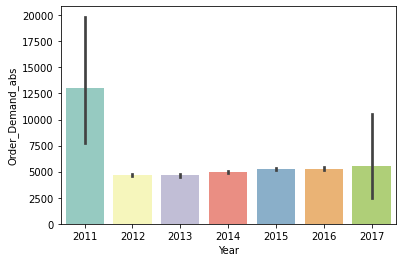

<Figure size 720x360 with 0 Axes>

In [206]:
sns.barplot(y=df_cpy['Order_Demand_abs'],x=df_cpy.Year,palette="Set3")
plt.figure(figsize = (10, 5))


In [181]:
df_cpy['Order_Demand_abs'].describe()

count    1.037336e+06
mean     4.949384e+03
std      2.907344e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand_abs, dtype: float64

In [177]:
df_cpy['Order_Demand_abs'].skew()

31.432925049321977

[Text(0.5, 0, 'Order Demand')]

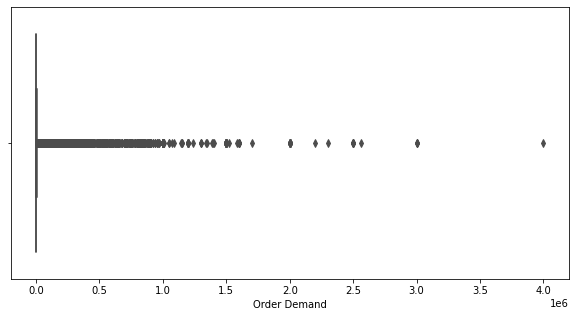

In [219]:
plt.figure(figsize = (10, 5))
sns.boxplot(df_cpy['Order_Demand_abs'],color='orange').set(xlabel='Order Demand')

Text(0.5, 1.0, 'Normalized data')

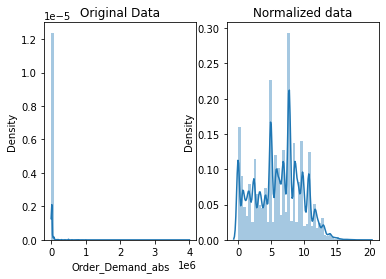

In [220]:
orders = df_cpy['Order_Demand_abs']

pos_orders = orders[orders > 0]

# Normalize the pledges using Box-Cox
normalized_orders = stats.boxcox(pos_orders)[0]

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(orders, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_orders, ax=ax[1])
ax[1].set_title("Normalized data")

[Text(0.5, 0, 'Normalized Order Demand ')]

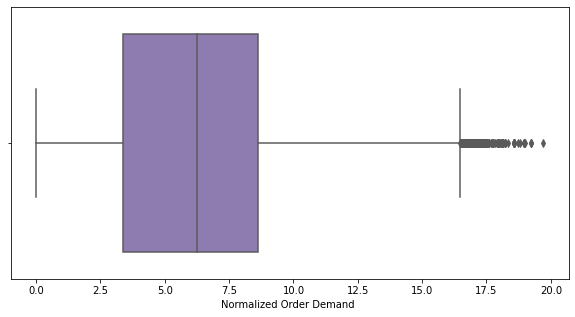

In [222]:
plt.figure(figsize = (10, 5))
sns.boxplot(normalized_orders,color='#8b73ba').set(xlabel='Normalized Order Demand ')

#### ▶  Production insights

In [224]:
df_cpy.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand',
       'Order_Demand_abs', 'Day', 'Month', 'Year', 'Quarter'],
      dtype='object')

#### Frequency of each warehouse

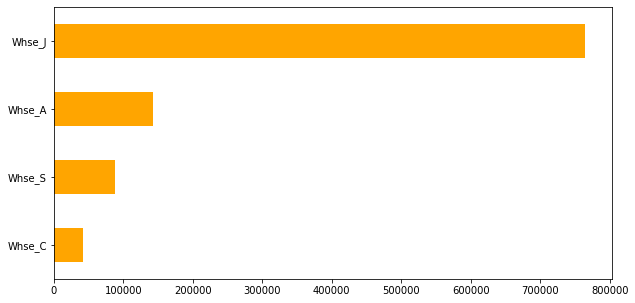

In [235]:
plt.figure(figsize = (10, 5))
df_cpy.Warehouse.value_counts().sort_values().plot(kind='barh',color = "orange")

#### Warehouse w.r.t Order Demands



In [227]:
# Amount of orders w.r.t Warehouses
warehouse_subset = df_cpy[["Warehouse","Order_Demand_abs"]]
warehouse_subset.groupby('Warehouse').sum().sort_values('Order_Demand_abs', ascending = False)

,Order_Demand_abs
Warehouse,
Whse_J,3363200396
Whse_S,1038024700
Whse_C,585071404
Whse_A,147877431


#### Frequency of each product category

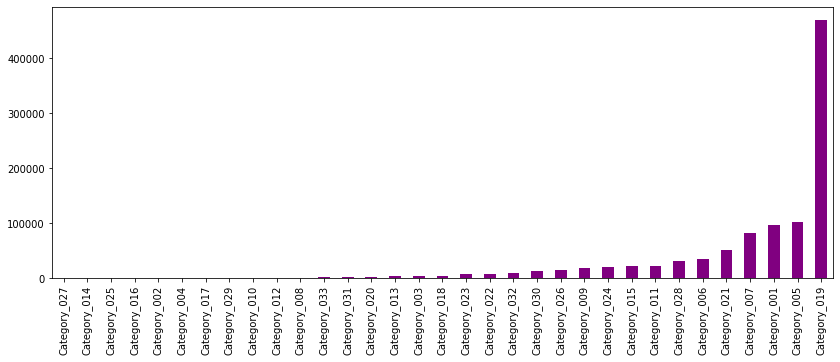

In [241]:
plt.figure(figsize = (14, 5))
df_cpy.Product_Category.value_counts().sort_values().plot(kind='bar',color = "purple")

#### ▶  Warehouse w.r.t Product Category

In [243]:
# Amount of orders w.r.t Product Category
prod_subset = df_cpy[["Product_Category","Order_Demand_abs"]]
prod_subset.groupby('Product_Category').sum().sort_values('Order_Demand_abs', ascending = False)

,Order_Demand_abs
Product_Category,
Category_019,4240159257
Category_006,405571330
Category_005,199674520
Category_007,128691531
Category_028,49055354
Category_033,42610000
Category_030,40966555
Category_021,4480570
Category_032,4473048


In [254]:
print( " Top 5 Product Categories contributing to Demand Orders are :- \n\n ", pd.DataFrame(prod_subset.groupby('Product_Category').sum().sort_values('Order_Demand_abs', ascending = False)).head(5))

 Top 5 Product Categories contributing to Demand Orders are :- 

                    Order_Demand_abs
Product_Category                  
Category_019            4240159257
Category_006             405571330
Category_005             199674520
Category_007             128691531
Category_028              49055354


## Forecast model

### Theory
* Describe the basic theory behind the solution you have decided to apply

### Implementation
* What parameters have you consider to tune and why are those important for best-fit?